# Data Science in Healthcare

## Project 3 - Medical Image Analysis

#### Submitted by: Sakshi Shende

Design and develop a CNN for malaria image analysis.

Read https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/ (Links to an external site.)

Download the data cell_images.zip from NIH: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ (Links to an external site.)


These are the steps to follow for this project:

1. Use dataset from NIH
2. Use the code I posted to divide the data into train/validation/test
3. Use VGG16 from keras - this is your feature extracting base model
4. Use the extract features code posted to extract features from train/validation/test
5. Save the features
6. Load the features
7. Define a model - this is your classifier that sits on top of the feature extractor
8. Call model.fit() with train and validation
9. Call model.evaluate() with test - the return of this call is the accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install --upgrade tensorflow

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil
import imutils
from imutils import paths
import tensorflow
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings('ignore')

## Divide data into train, validation and test set

In [ ]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = '/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/cell_images'

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis'

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the training* data
VAL_SPLIT = 0.1

In [ ]:
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
len(imagePaths)

27558

In [ ]:
# grab the paths to all input images in the original input directory and shuffle them
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

In [ ]:
# define the datasets that we'll be building
datasets = [
    ("training", trainPaths, TRAIN_PATH),
    ("validation", valPaths, VAL_PATH),
    ("testing", testPaths, TEST_PATH)
]

In [ ]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
    # loop over the input image paths
    for inputPath in imagePaths:
        # extract the filename of the input image along with its corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]
        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])
        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/training' directory
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/training/Parasitized' directory
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/training/Uninfected' directory
[INFO] building 'validation' split
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/validation' directory
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/validation/Parasitized' directory
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/validation/Uninfected' directory
[INFO] building 'testing' split
[INFO] 'creating /content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical I

In [ ]:
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
print(totalTrain)

19842


In [ ]:
totalVal = len(list(paths.list_images(VAL_PATH)))
print(totalVal)

2204


In [ ]:
totalTest = len(list(paths.list_images(TEST_PATH)))
print(totalTest)

5512


## Extract features

In [ ]:
conv_base = VGG16(weights = 'imagenet', include_top = False)
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
BS = 32

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    #class_mode="categorical",
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    shuffle=True,
    batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    VAL_PATH,
    #class_mode="categorical",
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
    TEST_PATH,
    #class_mode="categorical",
    class_mode="binary",
    target_size=(150, 150),
    color_mode="rgb",
    shuffle=False,
    batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,))
    i = 0
    batch_size = BS

    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)

        current_batch_size = min(features_batch.shape[0], sample_count - i * batch_size)

        features[i * batch_size: (i * batch_size) + current_batch_size] = features_batch[:current_batch_size]
        labels[i * batch_size: (i * batch_size) + current_batch_size] = labels_batch[:current_batch_size]

        i += 1

        if ((i * batch_size % 1000) == 0):
            print("processed size =", i * batch_size)

        if i * batch_size >= sample_count:
            break

    return features, labels

In [ ]:
trainFeatures,trainLabels = extract_features(trainGen,totalTrain)

# save the extracted features and labels
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_train_features', trainFeatures)
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_train_labels', trainLabels)

1/1 [==============================] - 7s 7s/step
processed size = 4000
1/1 [==============================] - 10s 10s/step
processed size = 8000
1/1 [==============================] - 9s 9s/step
processed size = 12000
1/1 [==============================] - 10s 10s/step
processed size = 16000
1/1 [==============================] - 1s 582ms/step


In [ ]:
valFeatures,valLabels = extract_features(valGen,totalVal)

# save the extracted features and labels
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_val_features', valFeatures)
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_val_labels', valLabels)

1/1 [==============================] - 6s 6s/step


In [ ]:
testFeatures, testLabels = extract_features(testGen,totalTest)

# save the extracted features and labels
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_test_features', testFeatures)
np.save('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_test_labels', testLabels)

1/1 [==============================] - 9s 9s/step
processed size = 4000
1/1 [==============================] - 3s 3s/step


In [ ]:
# load features and labels
trainFeatures = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_train_features.npy')
testFeatures = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_test_features.npy')
valFeatures = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_val_features.npy')

trainLabels = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_train_labels.npy')
testLabels = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_test_labels.npy')
valLabels = np.load('/content/drive/MyDrive/Colab Notebooks/Data Science in Healthcare/Medical Image Analysis/new features binary/VGG16_val_labels.npy')

In [ ]:
print(trainFeatures.shape, trainLabels.shape, valFeatures.shape, valLabels.shape, testFeatures.shape, testLabels.shape)

(19842, 4, 4, 512) (19842,) (2204, 4, 4, 512) (2204,) (5512, 4, 4, 512) (5512,)


## Define model and model training and evaluation

In [ ]:
model1 = Sequential()
model1.add(Flatten(input_shape=(4, 4, 512)))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model1.fit(trainFeatures, trainLabels, epochs= 25, batch_size=32, validation_data=(valFeatures, valLabels))

Epoch 1/25
621/621 [==============================] - 27s 41ms/step - loss: 0.2728 - accuracy: 0.8921 - val_loss: 0.3010 - val_accuracy: 0.8816
Epoch 2/25
621/621 [==============================] - 26s 42ms/step - loss: 0.1909 - accuracy: 0.9277 - val_loss: 0.1869 - val_accuracy: 0.9333
Epoch 3/25
621/621 [==============================] - 27s 44ms/step - loss: 0.1643 - accuracy: 0.9385 - val_loss: 0.2102 - val_accuracy: 0.9215
Epoch 4/25
621/621 [==============================] - 34s 55ms/step - loss: 0.1536 - accuracy: 0.9414 - val_loss: 0.1764 - val_accuracy: 0.9369
Epoch 5/25
621/621 [==============================] - 31s 50ms/step - loss: 0.1422 - accuracy: 0.9464 - val_loss: 0.1788 - val_accuracy: 0.9347
Epoch 6/25
621/621 [==============================] - 40s 64ms/step - loss: 0.1279 - accuracy: 0.9514 - val_loss: 0.2624 - val_accuracy: 0.8961
Epoch 7/25
621/621 [==============================] - 28s 46ms/step - loss: 0.1312 - accuracy: 0.9529 - val_loss: 0.1798 - val_accuracy:

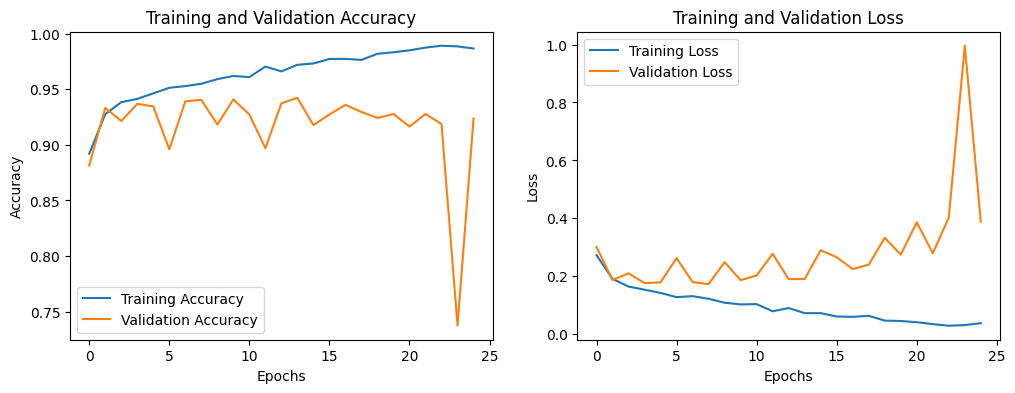

In [ ]:
# Plot the training accuracy and validation accuracy
plt.figure(figsize=(12, 4))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(testFeatures, testLabels)
print("Test Accuracy:", test_accuracy*100)

173/173 [==============================] - 2s 12ms/step - loss: 0.4538 - accuracy: 0.9209
Test Accuracy: 92.08998680114746


In [ ]:
# Evaluate the model on the validation  set
val_loss, val_accuracy = model1.evaluate(valFeatures, valLabels)
print("Validation Accuracy:", val_accuracy*100)

69/69 [==============================] - 1s 17ms/step - loss: 0.3882 - accuracy: 0.9238
Validation Accuracy: 92.37749576568604


Epoch 1/30
621/621 [==============================] - 25s 38ms/step - loss: 0.3974 - accuracy: 0.8365 - val_loss: 0.3304 - val_accuracy: 0.8716
Epoch 2/30
621/621 [==============================] - 22s 35ms/step - loss: 0.2644 - accuracy: 0.8965 - val_loss: 0.2178 - val_accuracy: 0.9152
Epoch 3/30
621/621 [==============================] - 22s 36ms/step - loss: 0.2374 - accuracy: 0.9092 - val_loss: 0.1866 - val_accuracy: 0.9247
Epoch 4/30
621/621 [==============================] - 22s 36ms/step - loss: 0.2274 - accuracy: 0.9121 - val_loss: 0.2667 - val_accuracy: 0.8848
Epoch 5/30
621/621 [==============================] - 21s 35ms/step - loss: 0.2175 - accuracy: 0.9196 - val_loss: 0.2833 - val_accuracy: 0.8984
Epoch 6/30
621/621 [==============================] - 20s 33ms/step - loss: 0.2101 - accuracy: 0.9207 - val_loss: 0.2663 - val_accuracy: 0.9165
Epoch 7/30
621/621 [==============================] - 21s 33ms/step - loss: 0.2050 - accuracy: 0.9237 - val_loss: 0.1824 - val_accuracy:

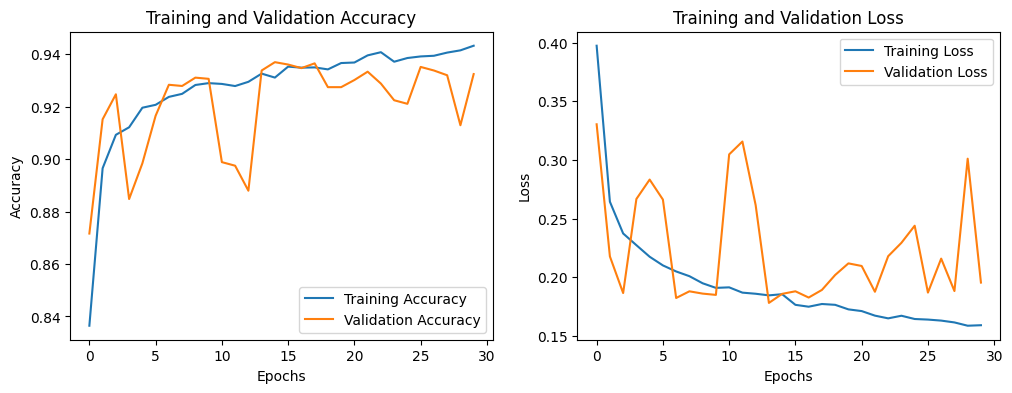

In [ ]:
# Build the classifier model on top of VGG16 base
model2 = Sequential()
model2.add(Flatten(input_shape=(4, 4, 512)))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(trainFeatures, trainLabels, epochs=30, batch_size=BS, validation_data=(valFeatures, valLabels))

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(testFeatures, testLabels)
print('Test accuracy:', test_acc*100)

# Evaluate the model on the validation  set
val_loss, val_accuracy = model2.evaluate(valFeatures, valLabels)
print("Validation Accuracy:", val_accuracy*100)

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(12, 4))

# Plot Training Accurac]4
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/30
621/621 [==============================] - 21s 33ms/step - loss: 0.3320 - accuracy: 0.8549 - val_loss: 0.2542 - val_accuracy: 0.9070
Epoch 2/30
621/621 [==============================] - 20s 33ms/step - loss: 0.2384 - accuracy: 0.9052 - val_loss: 0.2302 - val_accuracy: 0.9152
Epoch 3/30
621/621 [==============================] - 20s 32ms/step - loss: 0.2107 - accuracy: 0.9169 - val_loss: 0.1818 - val_accuracy: 0.9288
Epoch 4/30
621/621 [==============================] - 19s 31ms/step - loss: 0.1996 - accuracy: 0.9240 - val_loss: 0.2187 - val_accuracy: 0.9165
Epoch 5/30
621/621 [==============================] - 20s 33ms/step - loss: 0.1899 - accuracy: 0.9272 - val_loss: 0.2118 - val_accuracy: 0.9201
Epoch 6/30
621/621 [==============================] - 21s 33ms/step - loss: 0.1817 - accuracy: 0.9303 - val_loss: 0.1926 - val_accuracy: 0.9270
Epoch 7/30
621/621 [==============================] - 20s 33ms/step - loss: 0.1751 - accuracy: 0.9333 - val_loss: 0.1812 - val_accuracy:

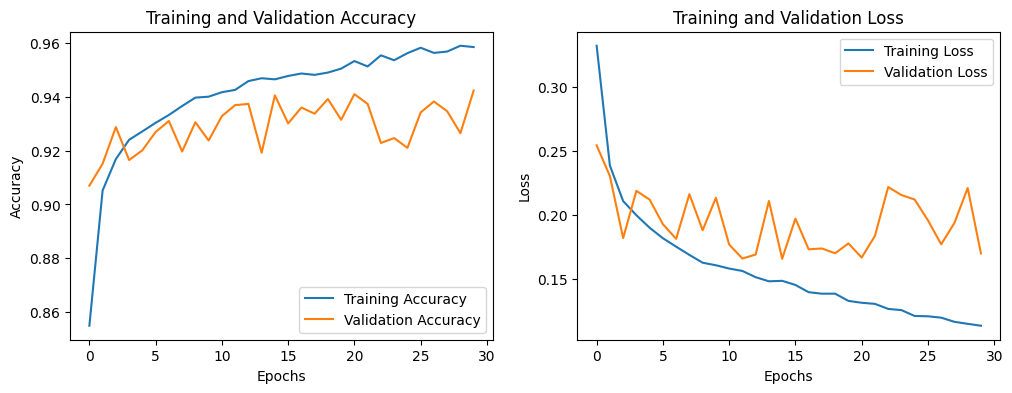

In [ ]:
# Build the classifier model on top of VGG16 base
model2 = Sequential()
model2.add(Flatten(input_shape=(4, 4, 512)))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(trainFeatures, trainLabels, epochs=30, batch_size=BS, validation_data=(valFeatures, valLabels))

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(testFeatures, testLabels)
print('Test accuracy:', test_acc*100)

# Evaluate the model on the validation  set
val_loss, val_accuracy = model2.evaluate(valFeatures, valLabels)
print("Validation Accuracy:", val_accuracy*100)

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(12, 4))

# Plot Training Accurac]4
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()